# 3. Domácí úkol BI-JUL: Počasí

## Add Dependencies
* If SystemError: longpath: Access is denied, install it from command prompt (run as an administrator)
* Uncomment if some package is missing

In [11]:
using Pkg
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("https://gitlab.fit.cvut.cz/BI-JUL/WLS.jl")
#Pkg.add("XLSX")
#Pkg.add("PyPlot")
#Pkg.add("Polynomials")
using DataFrames, CSV, PyPlot, XLSX, Polynomials, Statistics
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]; # general definition for the tasks

## Mauna Loa

### Task 1
* Načtěte tabulku s měřeními koncentrace CO2 na Mauna Loa observatoři a vytvořte graf reprezentující vývoj této veličiny.

In [2]:
# LOAD DATA FRAME
df  = DataFrame(CSV.File("data/monthly_in_situ_co2_mlo.csv", skipto=56)) #skipto says on which line it start loading the data
rename!(df,["Yr","Month","Excel Date","Date","CO2","CO2_SA","CO2_F","CO2_SAF","CO2_FL","CO2_SAFL"]) # units [ppm] = CO2 per mole, #SA - seasonally Adjusted, F - Fit, FL - Filled
allowmissing!(df) #no its Union{Floast64 and Missing}
df[df.CO2 .== -99.99,:CO2] .= missing #cannot set missing value to Float, hence the previous line
df = dropmissing(df, disallowmissing=true); #disallowmissing makes it only Floast64 again, faster computations

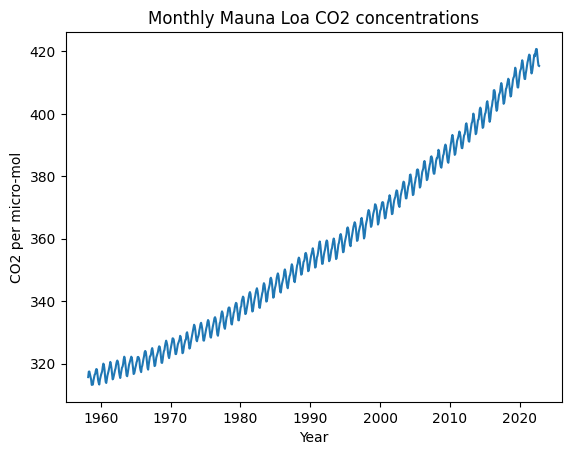

In [3]:
# PLOT IT
fig, ax = plt.subplots()
X = df.Date
Y = df.CO2
ax.plot(X,Y)
ax.set_title("Monthly Mauna Loa CO2 concentrations")
ax.set_ylabel("CO2 per micro-mol")
ax.set_xlabel("Year");

### Task 2
* Pomocí regrese (např. použijte balíček WLS.jl) zkuste argumentovat jaký trend nejlépe vystihuje tato data? Jde o lineární, kvadratický, kubický, nebo exponenciální růst?

Jedná se o kvadratický růst.

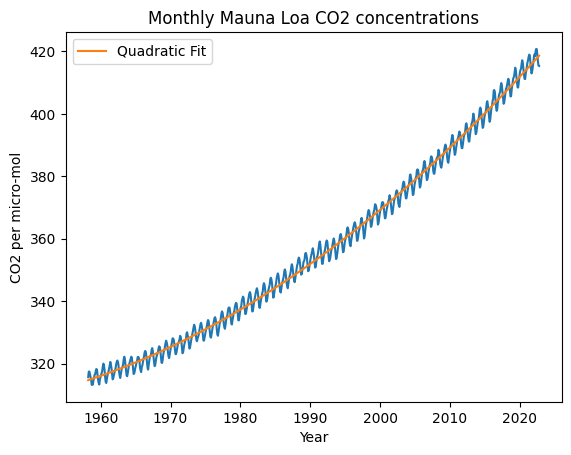

In [4]:
# REGRESSION
f = fit(X, Y, 2) #degree of two, result = 50150 - 51.64*x + 0.0133*x^2
ax.plot(X, f.(X), label="Quadratic Fit")
ax.legend()
fig

## Klementinum

### Task 1
* Načtěte tabulku s měřeními teploty v pražském Klementinu.

In [12]:
# LOAD DATA
df = DataFrame(XLSX.readtable("data/PKLM_pro_portal.xlsx", "data")) # data is name of the worksheet
df[!,:rok] = convert.(Int32,df[!,:rok]); # we need floar or int for fit in task4 

### Task 2 + Task 3
* Vypočtěte průměrné (jako průměry denních průměrných teplot) teploty pro každý měsíc (tj. pro leden 1775, leden 1776, leden 1777, atd.). Vytvořte grafy průměrných měsíčních teplot pro každý měsíc (tj. "lednový" graf bude zobrazovat průměrnou teplotu v lednu 1775, lednu 1776, lednu 1777, atd.).
* Vytvořte podobný graf pro minimální i maximální teploty v daném měsíc místo průměrné měsíční teploty v předchozím bodě.

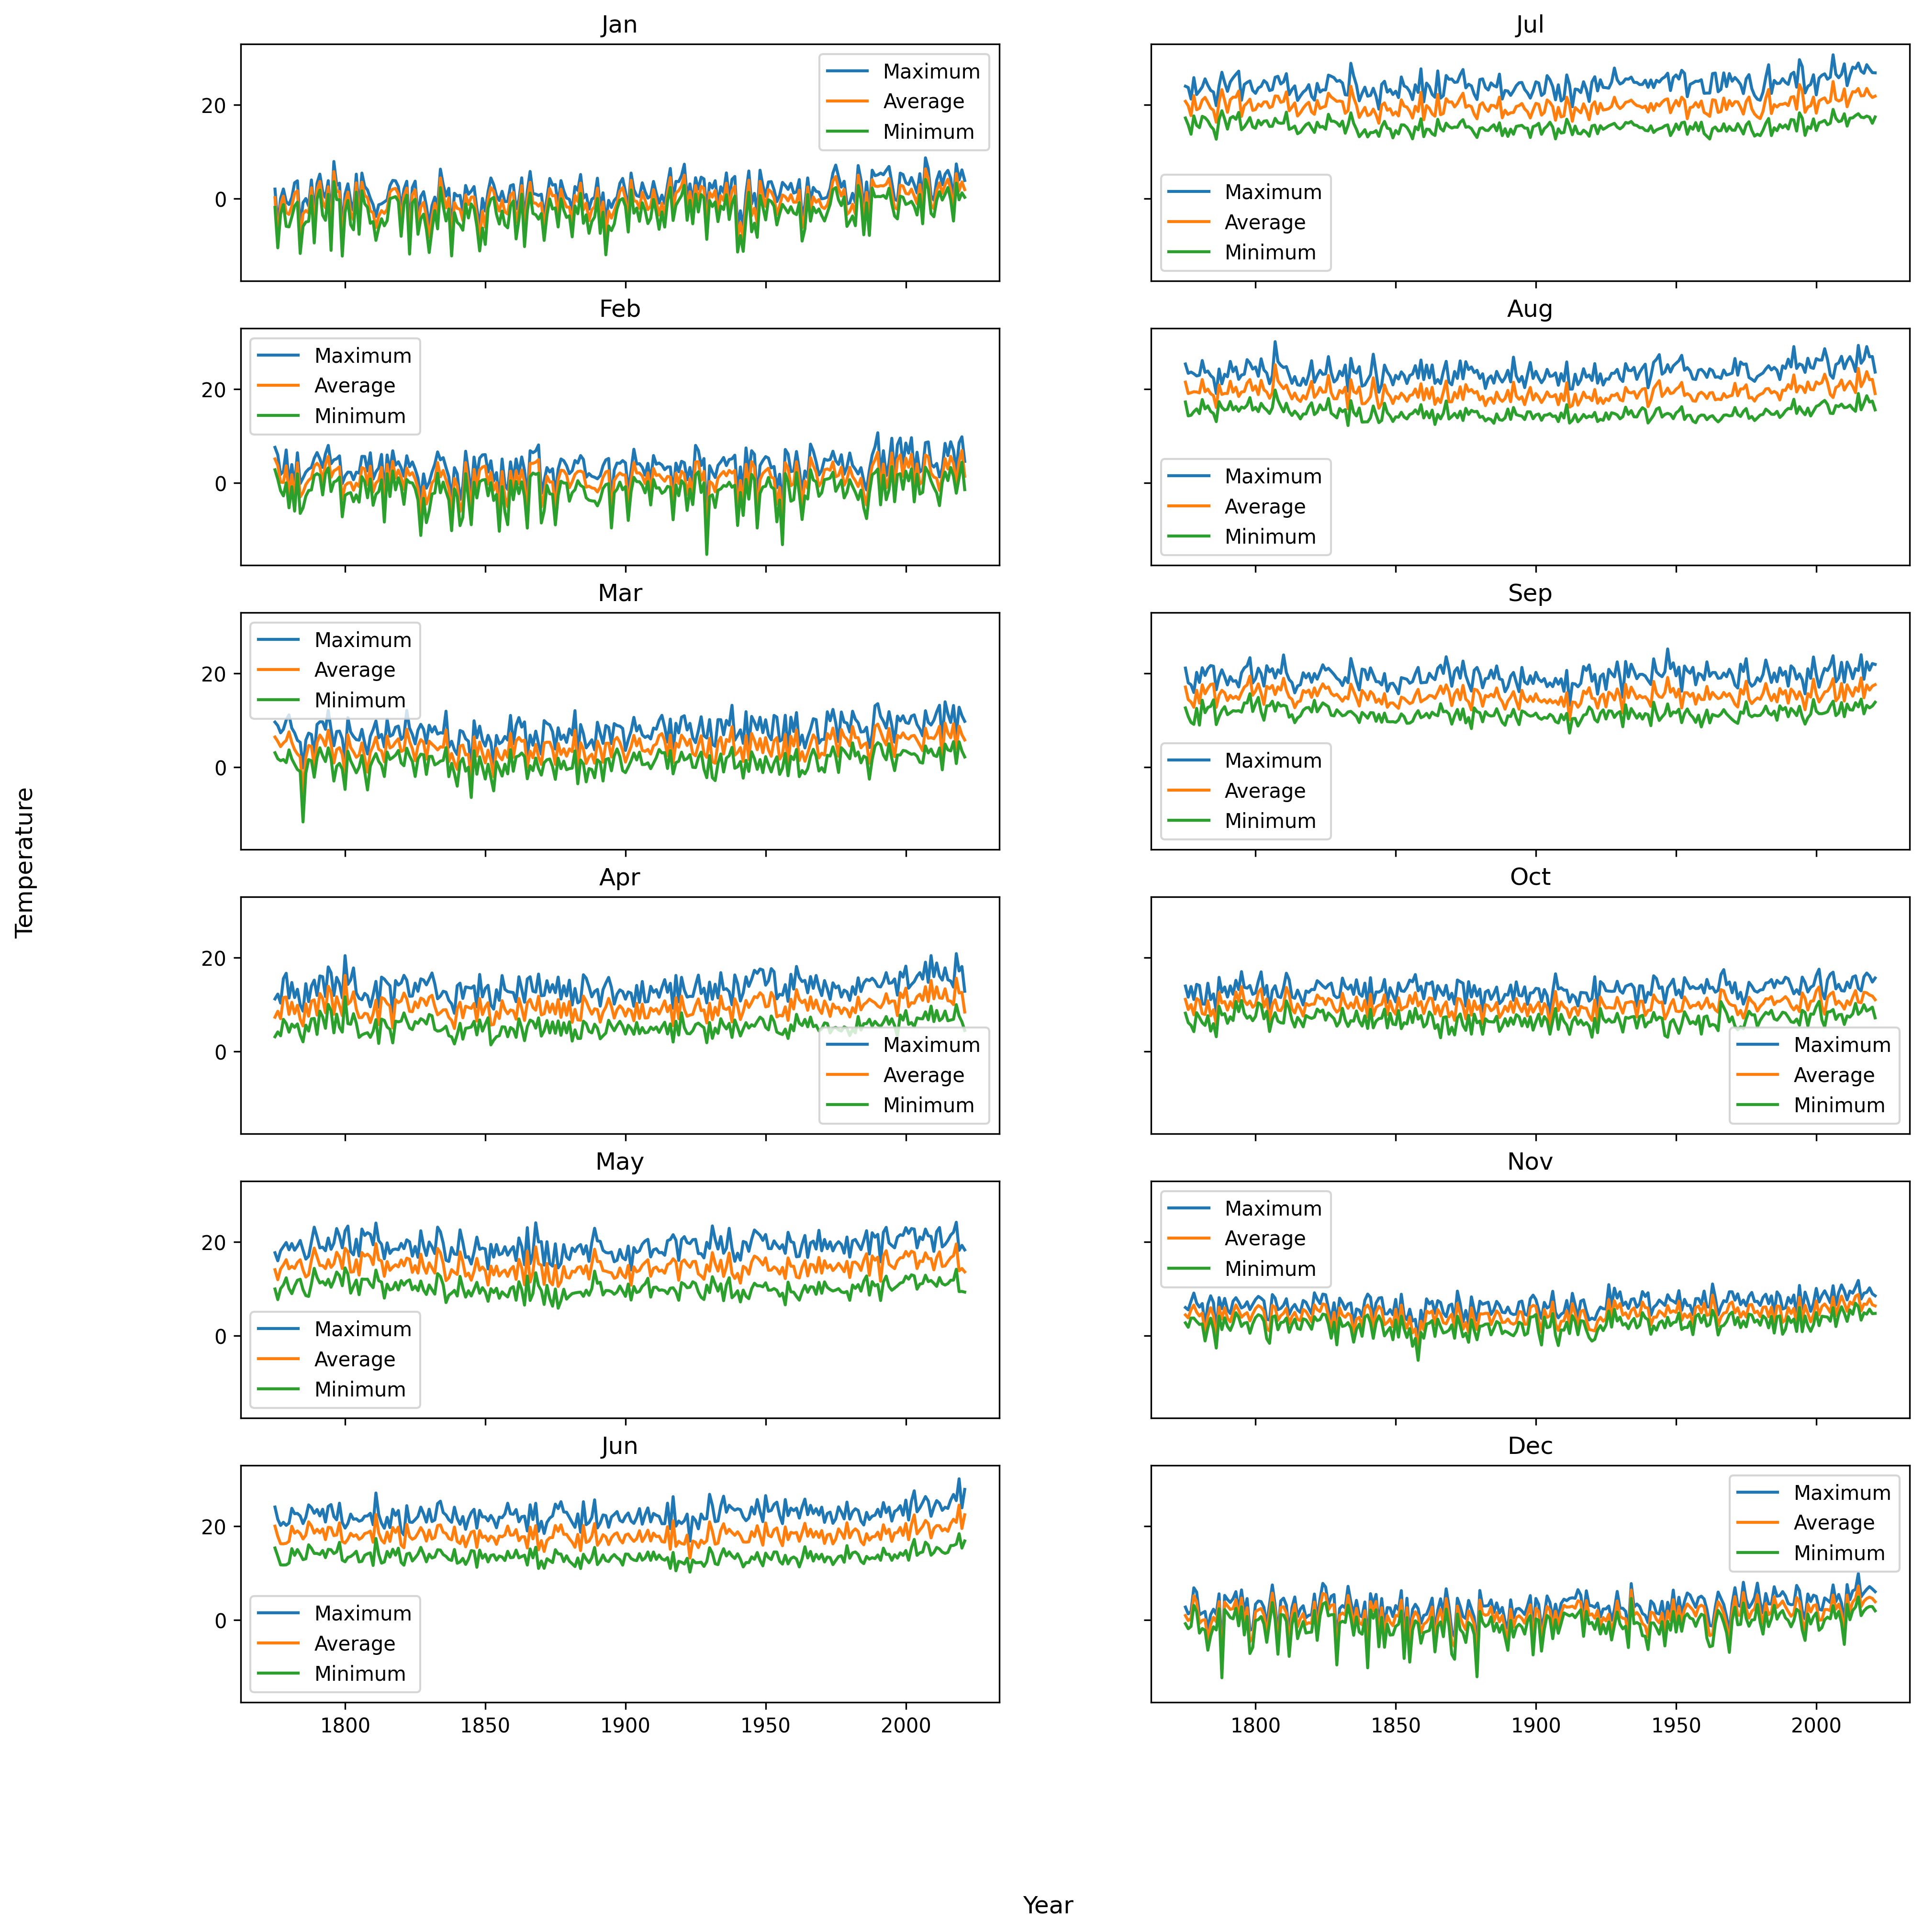

In [13]:
# COMPUTING MEAN
# https://dataframes.juliadata.org/stable/man/comparisons/#Grouping-data-and-aggregation
gd = groupby(df,:měsíc) #make 12 groups by month
fig, axs = plt.subplots(6,2,sharex=true, sharey=true,figsize=(15,15),dpi=300)
fig.supxlabel("Year")
fig.supylabel("Temperature")
for month in range(1,12)
    sgd = combine(groupby(gd[month],:rok), :"T-AVG" => mean, "TMI"=>mean, "TMA"=>mean) #subgroup data frame, mean of all days in month
    X = sgd.rok
    Y_avg = sgd."T-AVG_mean"
    Y_min = sgd."TMI_mean"
    Y_max = sgd."TMA_mean"
    axs[month].plot(X,Y_max,label="Maximum")
    axs[month].plot(X,Y_avg,label="Average")
    axs[month].plot(X,Y_min, label="Minimum")
    axs[month].set_title(months[month])
    axs[month].legend()
end

### Task 4
* Pozorujete v datech nějaký trend? Například v poslední 50 nebo 25 letech?

Ano, teplota mírně stoupá. 

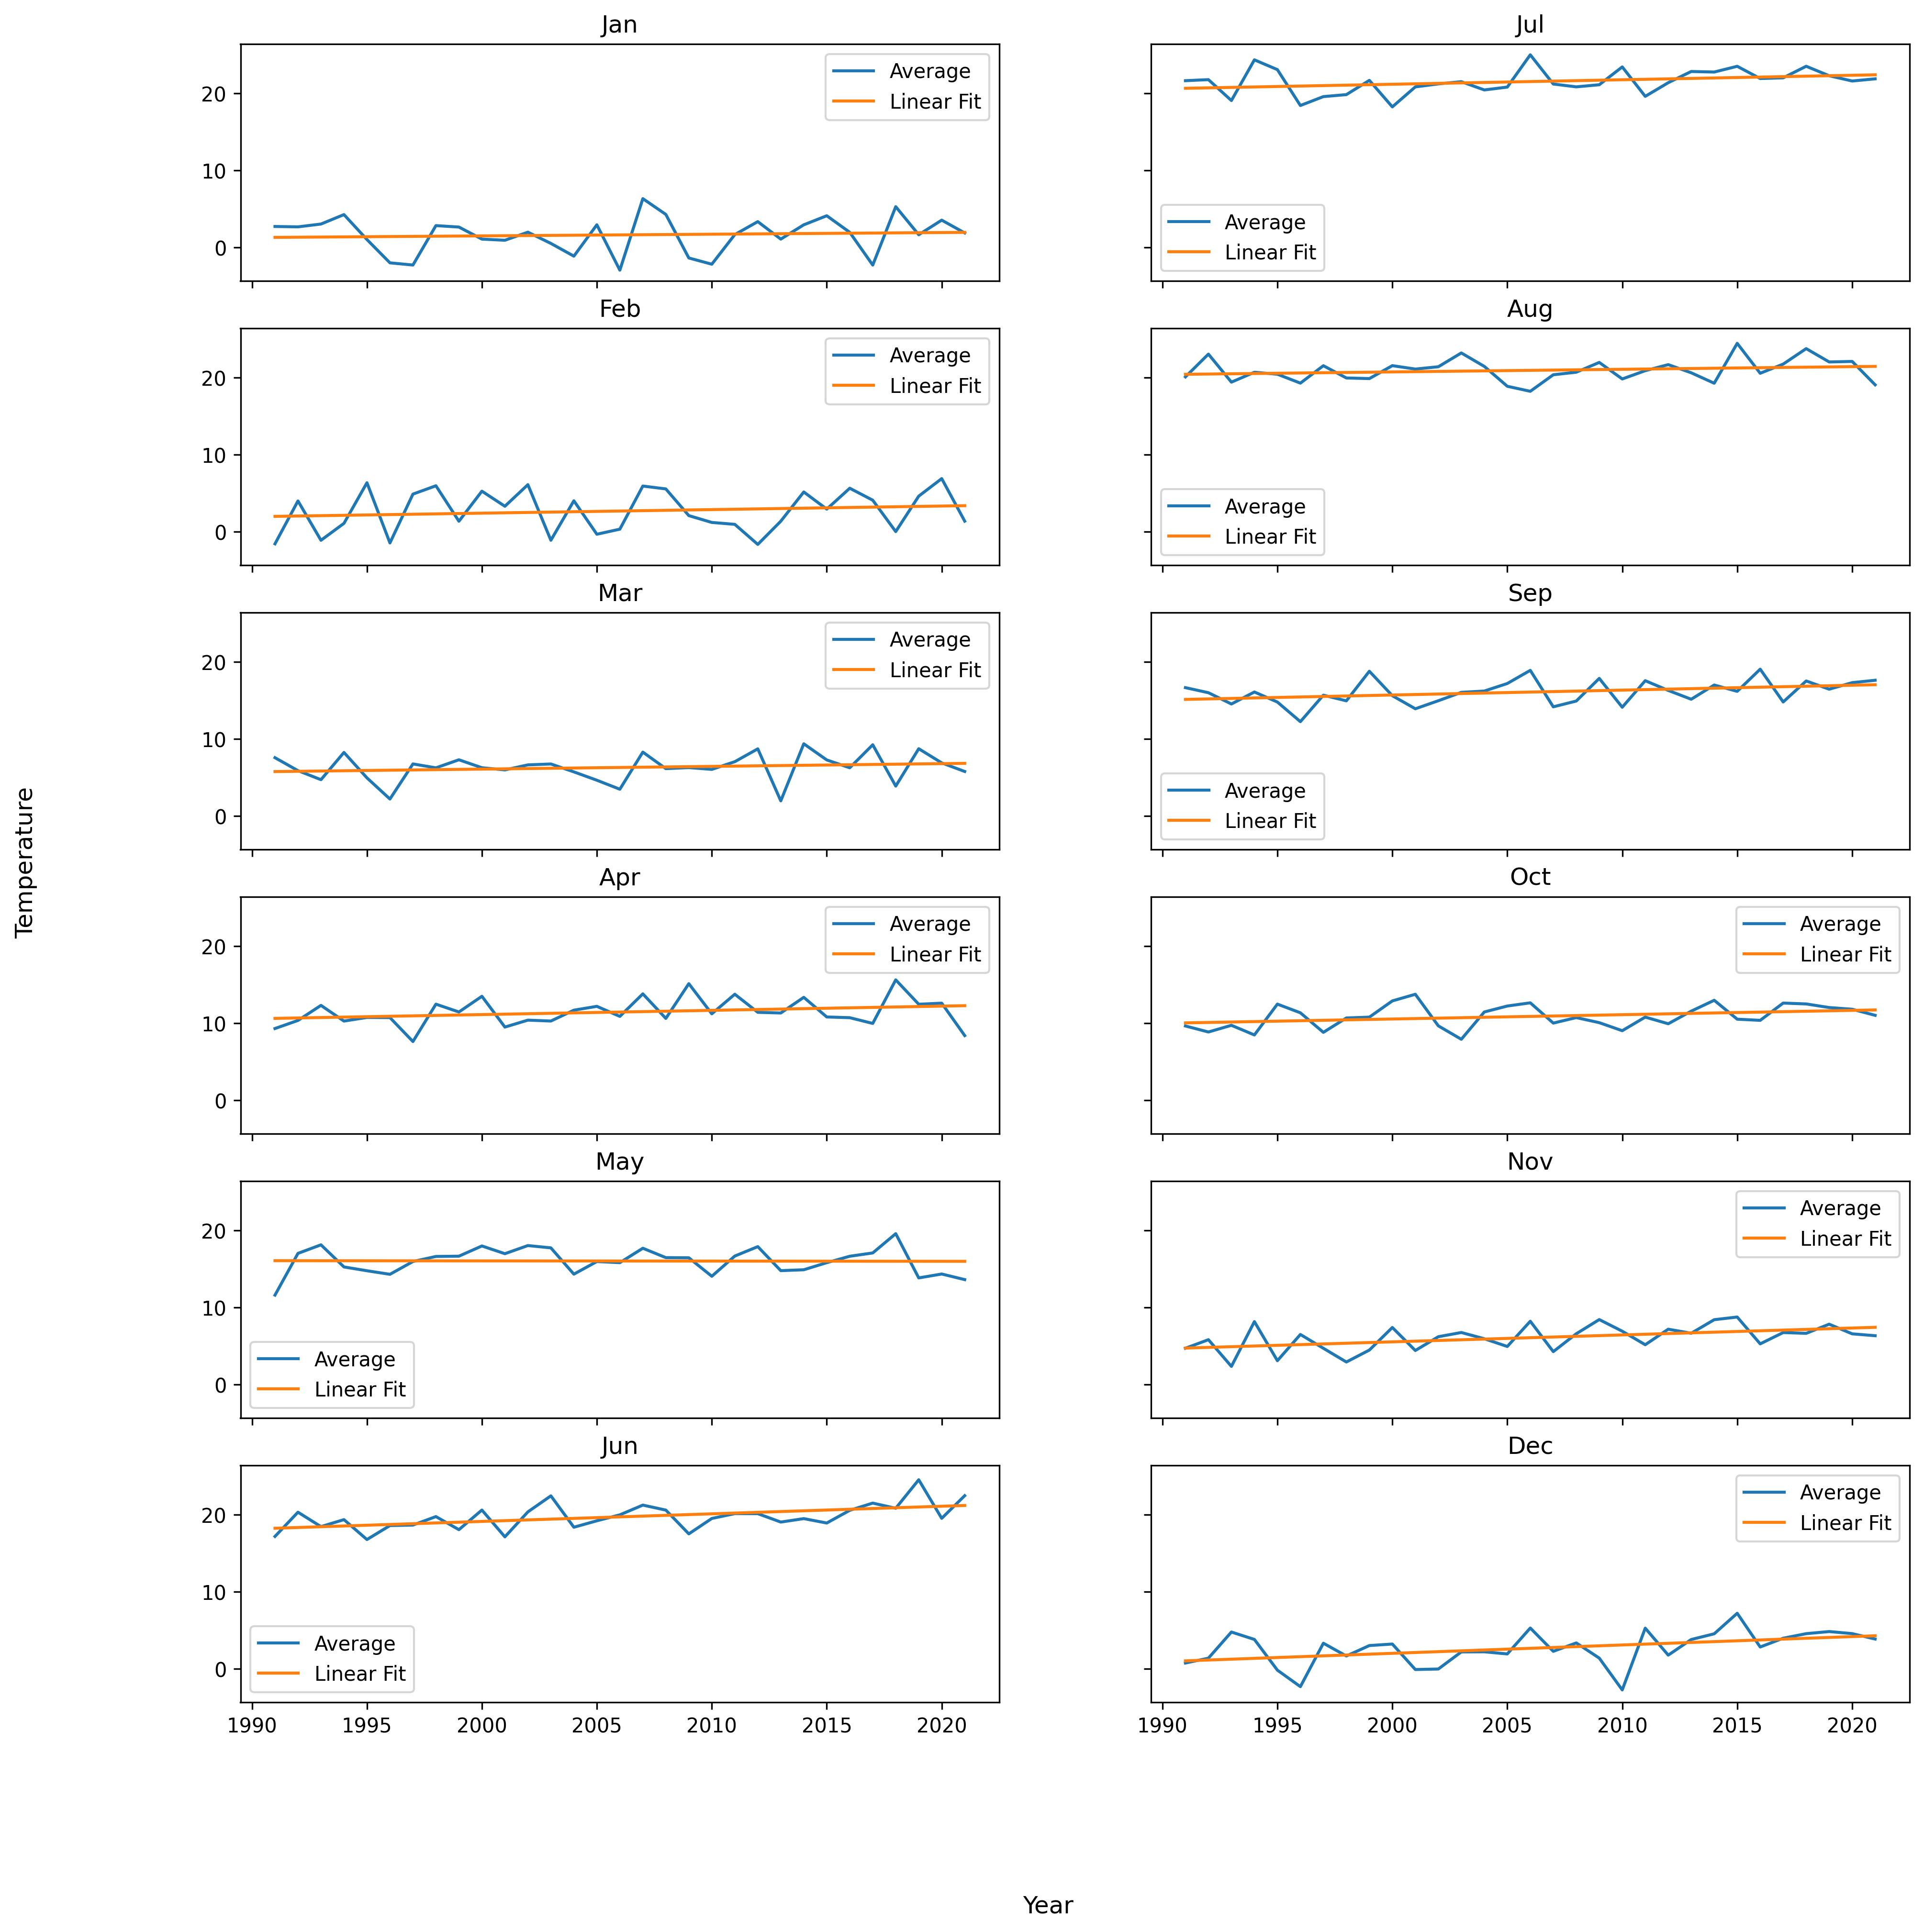

In [14]:
# REFRESSION
df = filter(Row -> Row["rok"] > 1990, df)
gd = groupby(df,:měsíc) #make 12 groups by month
fig, axs = plt.subplots(6,2,sharex=true, sharey=true,figsize=(15,15),dpi=300)
fig.supxlabel("Year")
fig.supylabel("Temperature")
for month in range(1,12)
    sgd = combine(groupby(gd[month],:rok), :"T-AVG" => mean) #subgroup data frame, mean of all days in month
    X = sgd.rok
    Y = sgd."T-AVG_mean"
    f = fit(X, Y, 1)
    axs[month].plot(X,Y,label="Average")
    axs[month].plot(X, f.(X), label="Linear Fit")
    axs[month].set_title(months[month])
    axs[month].legend()
end

## Oceány

### Task 1
* Načtěte tabulku ze souboru aravg.mon.ocean.90S.90N.v5.0.0.202210.asc.

In [8]:
# LOAD DATA
x = open("data/aravg.mon.ocean.90S.90N.v5.0.0.202210.asc")
df = DataFrame(Year = Int64[], Month = Int8[], Temperature = Float64[])
open("data/aravg.mon.ocean.90S.90N.v5.0.0.202210.asc") do fobj
    for line in eachline(fobj)
        line = filter(!=(""), split(line," "))[1:3] # remvoe spaces, leave only first column of meassurement
        line = parse.(Float64, line) # convert the substring to Vector{Float64}
        push!(df,line)
    end
end
gd = groupby(df,:Month);

### Task 2
* Vizualizujte časový vývoj odchylky průměrně globální teploty oceánů

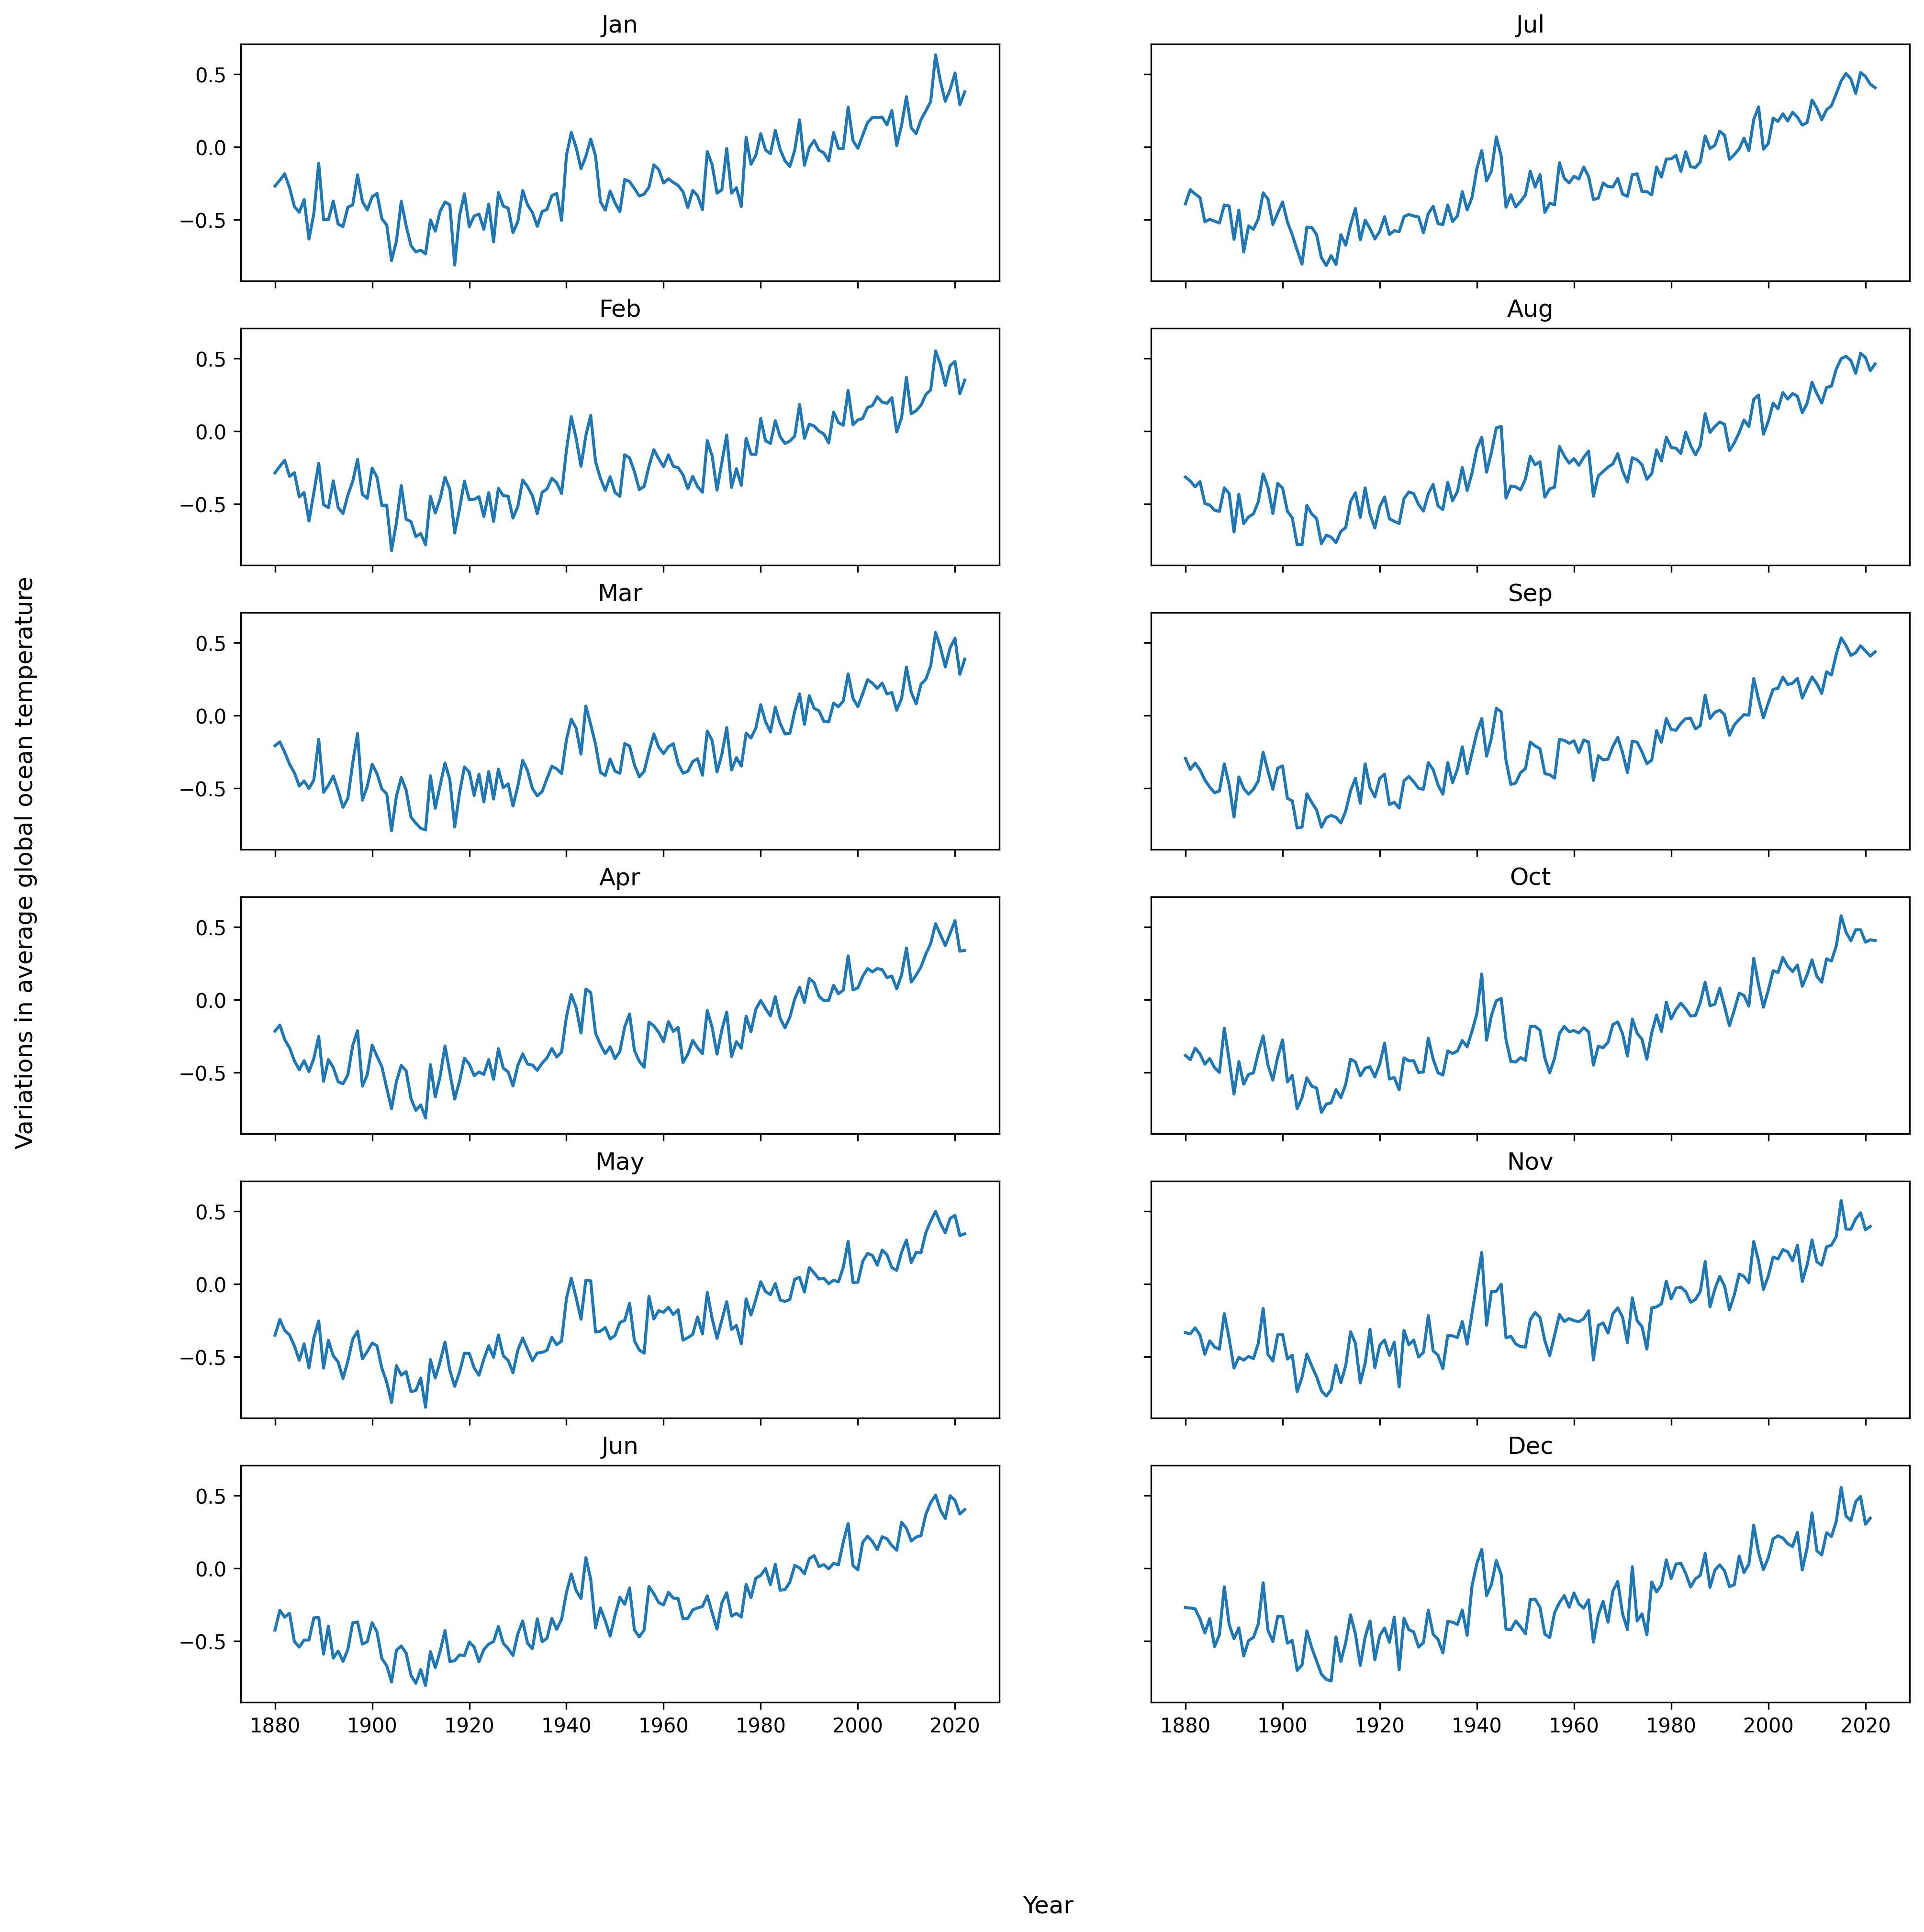

In [9]:
# PLOT IT
fig, axs = plt.subplots(6,2,sharex=true, sharey=true,figsize=(15,15),dpi=300)
fig.supxlabel("Year")
fig.supylabel("Variations in average global ocean temperature")
for month in range(1,12)
    X = gd[month].Year
    Y = gd[month].Temperature
    axs[month].plot(X,Y)
    axs[month].set_title(months[month])
end

### Task 3
* Opět pomocí regrese zkuse na datech trend v rámci jednotlivých měsíců.

Za posledních 140 let jsou data nejpodobnější cubic fit

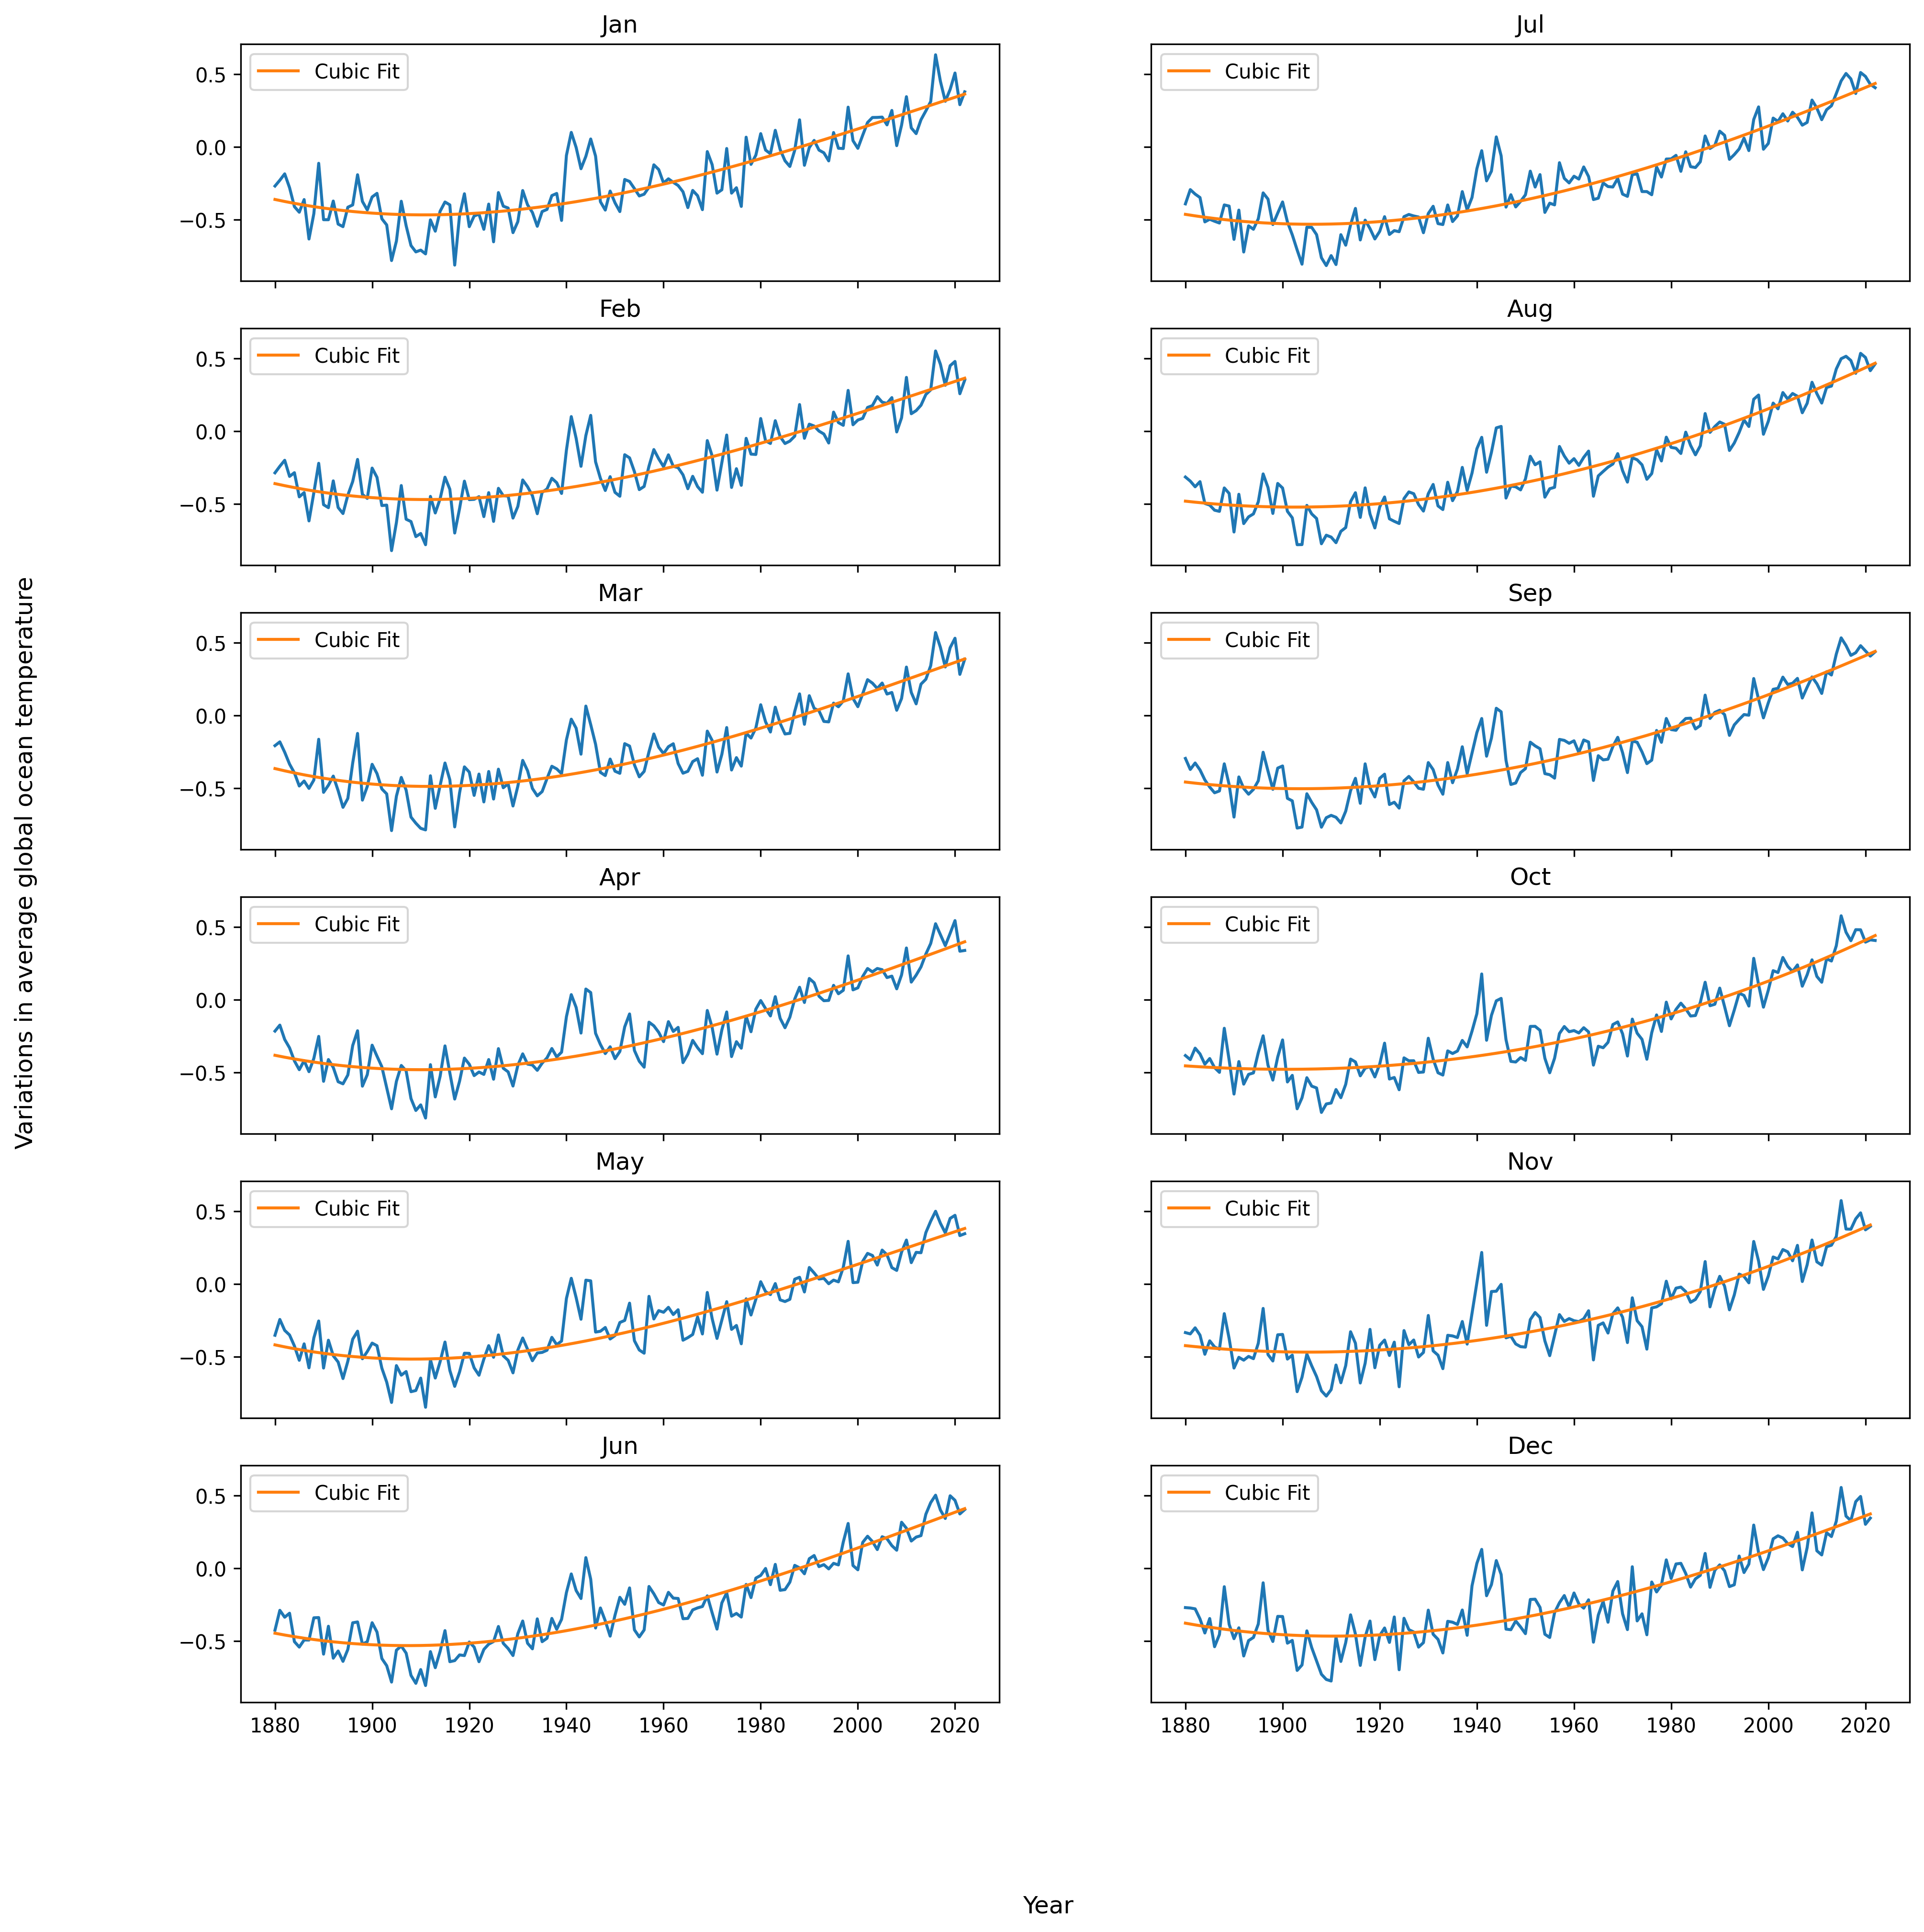

In [10]:
# REGRESSION
for month in range(1,12)
    X = gd[month].Year
    Y = gd[month].Temperature
    f = fit(X, Y, 3)
    axs[month].plot(X, f.(X), label="Cubic Fit")
    axs[month].legend()
end
fig